In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

In [2]:
!pip install graphviz

In [3]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

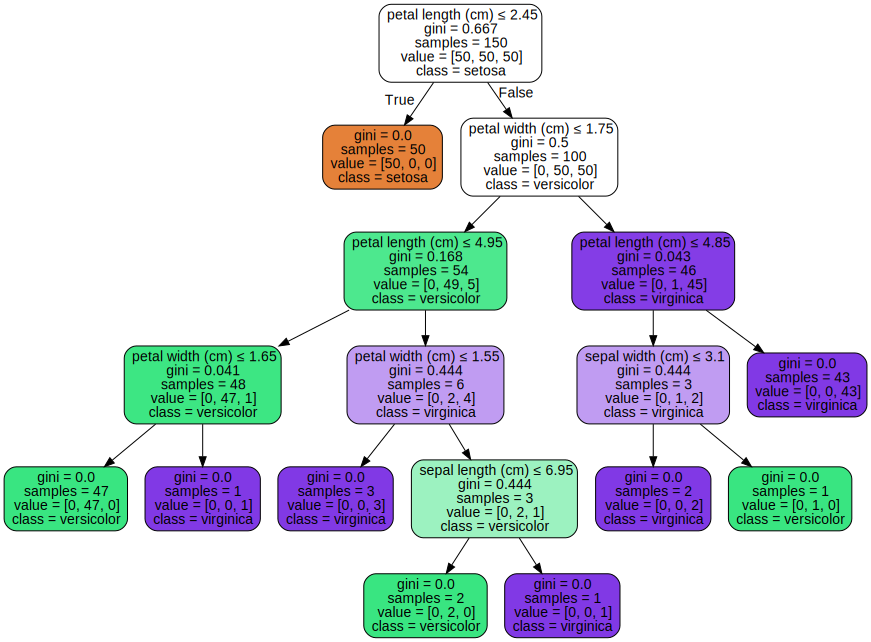

In [4]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

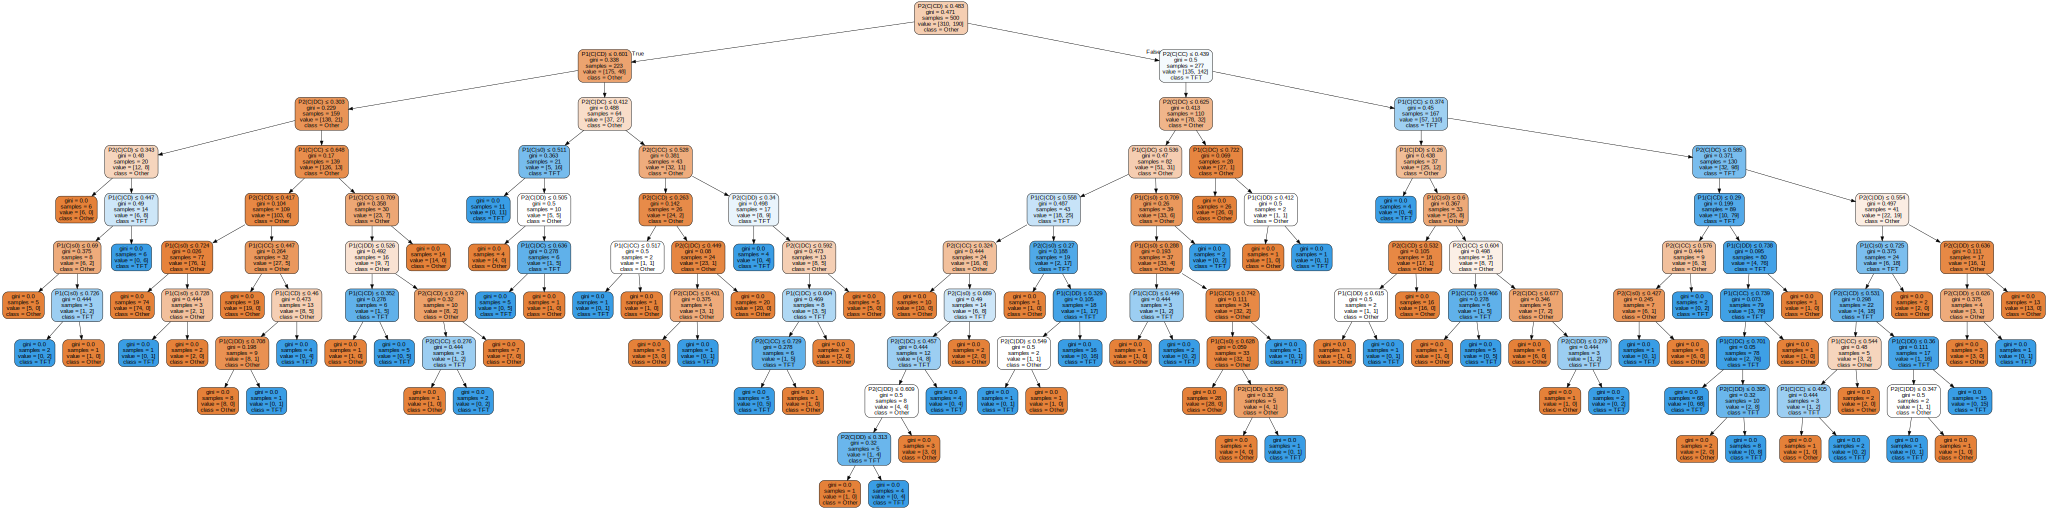

In [23]:
import numpy as np
import json
from result_collection.helper_func import *

# Given a policy for both agents ([P1, P2]),
# immediate reward function, r1 and r2, and the discount factor gamma
# calculate and return the value function
def calculate_value_fn_from_policy(end_policy, r1, r2, gamma):
    # Average reward per time step
    x1 = end_policy[0]
    x2 = end_policy[1]
    P = np.stack((x1 * x2, x1 * (1 - x2), (1 - x1) * x2, (1 - x1) * (1 - x2))).T

    I = np.eye(4)
    Zinv1 = np.linalg.inv(I - gamma * P[1:, :])
    Zinv2 = np.linalg.inv(I - gamma * P[1:, :])

    V1 = np.matmul(np.matmul(P[0, :], Zinv1), r1)
    V2 = np.matmul(np.matmul(P[0, :], Zinv2), r2)
    return V1, V2

# Loads json results given path to json file
def load_results(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

# Given single experiment results in json format
# extracts initial policies for both agents
def get_initial_policies(results):
    policies = []
    for experiment in results["results"]["seeds"]:
        policies.append([experiment["epoch"][0]["P1"], experiment["epoch"][0]["P2"]])
    return policies

def plot_decistion_tree_TFT(path):
    results = load_results(path)
    X = np.array(get_initial_policies(results))
    _, _, TFT1, TFT2 = get_end_R_std_TFT(results)

    labels = []
    for t in TFT1:
        if t >= 0.99:
            labels.append("b")
        else:
            labels.append("r")

    for i, t in enumerate(TFT2):
        if t < 0.9:
            labels[i] = "r"

    Y = np.concatenate((X[:, 0, :], X[:, 1, :]), 1)
    graph = visualise_decision(Y, labels)
    return graph
    

def visualise_decision(X, labels):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, [0 if 'r' == l else 1 for l in labels])

    feature_names = ["P1(C|s0)", "P1(C|CC)", "P1(C|CD)", "P1(C|DC)", "P1(C|DD)"]
    if len(X[0, :]) == 10:
        feature_names = ["P1(C|s0)", "P1(C|CC)", "P1(C|CD)", "P1(C|DC)", "P1(C|DD)",
                         "P2(C|s0)", "P2(C|CC)", "P2(C|DC)", "P2(C|CD)", "P2(C|DD)"]

    dot_data = tree.export_graphviz(clf, out_file=None)
    graph = graphviz.Source(dot_data)
    graph.render("iris")
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=feature_names,
                                    class_names=["Other", "TFT"],
                                    filled=True, rounded=True,
                                    special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

graph = plot_decistion_tree_TFT("results/lola1_random_init_policy_robustness/R25/lola1_vs_lola1_IPD.json")
graph

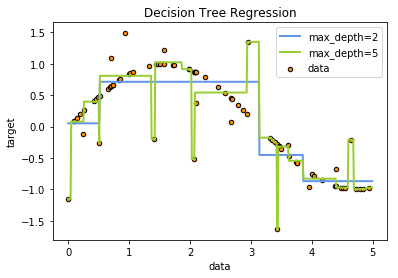

In [14]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()